In [38]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys
import time
import timeit
from collections import namedtuple
import os
import glob


from matplotlib import pyplot as plt
from matplotlib import cm
matplotlib.style.use('ggplot')

import io
import base64
from IPython.display import HTML

In [41]:
basehash = hash



class IHT:

    "Structure to handle collisions"

    def __init__(self, sizeval):

        self.size = sizeval

        self.overfullCount = 0

        self.dictionary = {}



    def __str__(self):

        "Prepares a string for printing whenever this object is printed"

        return "Collision table:" + " size:" + str(self.size) + " overfullCount:" + str(self.overfullCount) + " dictionary:" + str(len(self.dictionary)) + " items"



    def count (self):

        return len(self.dictionary)



    def fullp (self):

        return len(self.dictionary) >= self.size



    def getindex (self, obj, readonly=False):

        d = self.dictionary

        if obj in d: return d[obj]

        elif readonly: return None

        size = self.size

        count = self.count()

        if count >= size:

            if self.overfullCount==0: print('IHT full, starting to allow collisions')

            self.overfullCount += 1

            return basehash(obj) % self.size

        else:

            d[obj] = count

            return count



def hashcoords(coordinates, m, readonly=False):

    if type(m)==IHT: return m.getindex(tuple(coordinates), readonly)

    if type(m)==int: return basehash(tuple(coordinates)) % m

    if m==None: return coordinates



from math import floor, log

from itertools import zip_longest



def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):

    """returns num-tilings tile indices corresponding to the floats and ints"""

    qfloats = [floor(f*numtilings) for f in floats]

    Tiles = []

    for tiling in range(numtilings):

        tilingX2 = tiling*2

        coords = [tiling]

        b = tiling

        for q in qfloats:

            coords.append( (q + b) // numtilings )

            b += tilingX2

        coords.extend(ints)

        Tiles.append(hashcoords(coords, ihtORsize, readonly))

    return Tiles



def tileswrap (ihtORsize, numtilings, floats, wrawidths, ints=[], readonly=False):

    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""

    qfloats = [floor(f*numtilings) for f in floats]

    Tiles = []

    for tiling in range(numtilings):

        tilingX2 = tiling*2

        coords = [tiling]

        b = tiling

        for q, width in zip_longest(qfloats, wrapwidths):

            c = (q + b%numtilings) // numtilings

            coords.append(c%width if width else c)

            b += tilingX2

        coords.extend(ints)

        Tiles.append(hashcoords(coords, ihtORsize, readonly))

    return Tiles

In [42]:
env = gym.make("MountainCar-v0")
env._max_episode_steps = 3000  # Increase upper time limit so we can plot full behaviour.
np.random.seed(6)

c:\python35\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [44]:
class QEstimator():
    """
    Linear action-value (q-value) function approximator for 
    semi-gradient methods with state-action featurization via tile coding. 
    """
    
    def __init__(self, step_size, num_tilings=8, max_size=4096, tiling_dim=None, trace=False):
        
        self.trace = trace
        self.max_size = max_size
        self.num_tilings = num_tilings
        self.tiling_dim = tiling_dim or num_tilings

        # Step size is interpreted as the fraction of the way we want 
        # to move towards the target. To compute the learning rate alpha,
        # scale by number of tilings. 
        self.alpha = step_size / num_tilings

        # Initialize index hash table (IHT) for tile coding.
        # This assigns a unique index to each tile up to max_size tiles.
        # Ensure max_size >= total number of tiles (num_tilings x tiling_dim x tiling_dim)
        # to ensure no duplicates.
        self.iht = IHT(max_size)

        # Initialize weights (and optional trace)
        self.weights = np.zeros(max_size)
        if self.trace:
            self.z = np.zeros(max_size)

        # Tilecoding software partitions at integer boundaries, so must rescale
        # position and velocity space to span tiling_dim x tiling_dim region.
        self.position_scale = self.tiling_dim / (env.observation_space.high[0] \
                                                  - env.observation_space.low[0])
        self.velocity_scale = self.tiling_dim / (env.observation_space.high[1] \
                                                  - env.observation_space.low[1])
        
    def featurize_state_action(self, state, action):
        """
        Returns the featurized representation for a 
        state-action pair.
        """
        featurized = tiles(self.iht, self.num_tilings, 
                           [self.position_scale * state[0], 
                            self.velocity_scale * state[1]], 
                           [action])
        return featurized
    
    def predict(self, s, a=None):
        """
        Predicts q-value(s) using linear FA.
        If action a is given then returns prediction
        for single state-action pair (s, a).
        Otherwise returns predictions for all actions 
        in environment paired with s.   
        """
    
        if a is None:
            features = [self.featurize_state_action(s, i) for 
                        i in range(env.action_space.n)]
        else:
            features = [self.featurize_state_action(s, a)]
            
        return [np.sum(self.weights[f]) for f in features]
        
            
    def update(self, s, a, target):
        """
        Updates the estimator parameters
        for a given state and action towards
        the target using the gradient update rule 
        (and the eligibility trace if one has been set).
        """
        features = self.featurize_state_action(s, a)
        estimation = np.sum(self.weights[features])  # Linear FA
        delta = (target - estimation)
        
        if self.trace:
            # self.z[features] += 1  # Accumulating trace
            self.z[features] = 1  # Replacing trace
            self.weights += self.alpha * delta * self.z
        else:
            self.weights[features] += self.alpha * delta
                
    
    def reset(self, z_only=False):
        """
        Resets the eligibility trace (must be done at 
        the start of every epoch) and optionally the
        weight vector (if we want to restart training
        from scratch).
        """
        
        if z_only:
            assert self.trace, 'q-value estimator has no z to reset.'
            self.z = np.zeros(self.max_size)
        else:
            if self.trace:
                self.z = np.zeros(self.max_size)
            self.weights = np.zeros(self.max_size)

In [45]:
def make_epsilon_greedy_policy(estimator, epsilon, num_actions):
    """
    Creates an epsilon-greedy policy based on a 
    given q-value approximator and epsilon.    
    """
    def policy_fn(observation):
        action_probs = np.ones(num_actions, dtype=float) * epsilon / num_actions
        q_values = estimator.predict(observation)
        best_action_idx = np.argmax(q_values)
        action_probs[best_action_idx] += (1.0 - epsilon)
        return action_probs
    return policy_fn

In [46]:
def sarsa_n(n, env, estimator, gamma=1.0, epsilon=0):
    """
    n-step semi-gradient Sarsa algorithm
    for finding optimal q and pi via Linear
    FA with n-step TD updates.
    """
    
    # Create epsilon-greedy policy
    policy = make_epsilon_greedy_policy(
        estimator, epsilon, env.action_space.n)

    # Reset the environment and pick the first action
    state = env.reset()
    action_probs = policy(state)
    action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

    # Set up trackers
    states = [state]
    actions = [action]
    rewards = [0.0]

    # Step through episode
    T = float('inf')
    for t in itertools.count():
        if t < T:           
            # Take a step
            next_state, reward, done, _ = env.step(action)
            states.append(next_state)
            rewards.append(reward)

            if done:
                T = t + 1

            else:
                # Take next step
                next_action_probs = policy(next_state)
                next_action = np.random.choice(
                    np.arange(len(next_action_probs)), p=next_action_probs)

                actions.append(next_action)

        update_time = t + 1 - n  # Specifies state to be updated
        if update_time >= 0:       
            # Build target
            target = 0
            for i in range(update_time + 1, min(T, update_time + n) + 1):
                target += np.power(gamma, i - update_time - 1) * rewards[i]
            if update_time + n < T:
                q_values_next = estimator.predict(states[update_time + n])
                target += q_values_next[actions[update_time + n]]
            
            # Update step
            estimator.update(states[update_time], actions[update_time], target)
        
        if update_time == T - 1:
            break

        state = next_state
        action = next_action
    
    ret = np.sum(rewards)
    
    return t, ret

In [47]:
def sarsa_lambda(lmbda, env, estimator, gamma=1.0, epsilon=0):
    
    """
    Sarsa(Lambda) algorithm
    for finding optimal q and pi via Linear
    FA with eligibility traces.
    """
    
    # Reset the eligibility trace
    estimator.reset(z_only=True)

    # Create epsilon-greedy policy
    policy = make_epsilon_greedy_policy(
        estimator, epsilon, env.action_space.n)

    # Reset the environment and pick the first action
    state = env.reset()
    action_probs = policy(state)
    action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

    ret = 0
    # Step through episode
    for t in itertools.count():
        # Take a step
        next_state, reward, done, _ = env.step(action)
        ret += reward

        if done:
            target = reward
            estimator.update(state, action, target)
            break

        else:
            # Take next step
            next_action_probs = policy(next_state)
            next_action = np.random.choice(
                np.arange(len(next_action_probs)), p=next_action_probs)

            # Estimate q-value at next state-action
            q_new = estimator.predict(
                next_state, next_action)[0]
            target = reward + gamma * q_new
            # Update step
            estimator.update(state, action, target)
            estimator.z *= gamma * lmbda

        state = next_state
        action = next_action    
    
    return t, ret
    

In [133]:
def plot_cost_to_go(env, estimator, num_partitions=100):
    """
    Plots -Q(s, a_max) for each state s=(position, velocity) 
    in the environment where a_max is the maximising action 
    from s according to our q-value estimator Q.
    The state-space is continuous hence we first discretise 
    it into num_partitions partitions in each dimension. 
    """
    
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_partitions)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_partitions)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(
        lambda obs: -np.max(estimator.predict(obs)), 2, np.stack([X, Y], axis=2))

    fig, ax = plt.subplots(figsize=(5, 5))
    p = ax.pcolor(X, Y, Z, cmap=cm.RdBu)
    
    ax.set_xlabel('Position', fontsize=25, color='black')
    ax.set_ylabel('Velocity', fontsize=25, color='black')
    ax.set_title("Value Function", fontsize=25)
    plt.tight_layout()
    plt.show()
    fig.savefig('original.png',dpi=400)

In [103]:
def generate_data(env, estimator, num_partitions=500):
    """
    Plots -Q(s, a_max) for each state s=(position, velocity) 
    in the environment where a_max is the maximising action 
    from s according to our q-value estimator Q.
    The state-space is continuous hence we first discretise 
    it into num_partitions partitions in each dimension. 
    """
    
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_partitions)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_partitions)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(
        lambda obs: -np.max(estimator.predict(obs)), 2, np.stack([X, Y], axis=2))

    return X,Y,Z

In [104]:
X,Y,Z = generate_data(env, estimator_n)

In [49]:
RunStats = namedtuple('RunStats', ['algorithm', 'steps', 'returns'])

In [50]:
def run(algorithm, num_episodes=500, **algorithm_kwargs):
    """
    Runs algorithm over multilple episodes and logs
    for each episode the complete return (G_t) and the
    number of steps taken.
    """
    
    stats = RunStats(
        algorithm=algorithm, 
        steps=np.zeros(num_episodes), 
        returns=np.zeros(num_episodes))
    
    algorithm_fn = globals()[algorithm]
    
    for i in range(num_episodes):
        episode_steps, episode_return = algorithm_fn(**algorithm_kwargs)
        stats.steps[i] = episode_steps
        stats.returns[i] = episode_return
        sys.stdout.flush()
        print("\rEpisode {}/{} Return {}".format(
            i + 1, num_episodes, episode_return), end="")
    return stats

Episode 500/500 Return -85.00

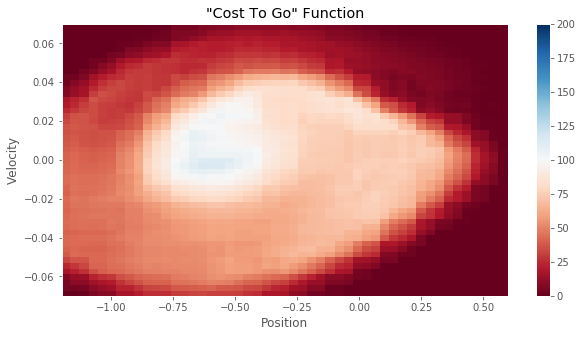

500 episodes completed in 38.46s


In [51]:
step_size = 0.5  # Fraction of the way we want to move towards target
n = 4  # Level of bootstrapping (set to intermediate value)
num_episodes = 500

estimator_n = QEstimator(step_size=step_size)

start_time = timeit.default_timer()
run_stats_n = run('sarsa_n', num_episodes, n=n, env=env, estimator=estimator_n)
elapsed_time = timeit.default_timer() - start_time

plot_cost_to_go(env, estimator_n)
print('{} episodes completed in {:.2f}s'.format(num_episodes, elapsed_time))

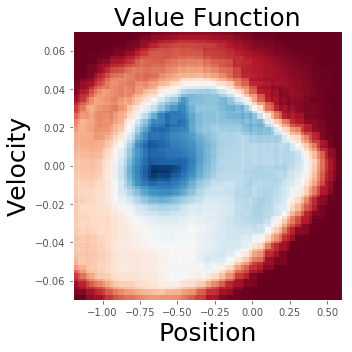

In [134]:
plot_cost_to_go(env, estimator_n)

Episode 500/500 Return -92.00

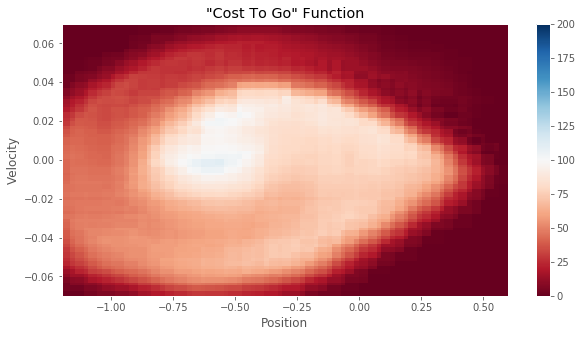

500 episodes completed in 30.94s


In [59]:
step_size = 0.5 # Fraction of the way we want to move towards target
lmbda = 0.92  # Level of bootstrapping (set to intermediate value)
num_episodes = 500

estimator_lambda = QEstimator(step_size=step_size, trace=True)

start_time = timeit.default_timer()
run_stats_lambda = run('sarsa_lambda', num_episodes, lmbda=lmbda, env=env, estimator=estimator_lambda)
elapsed_time = timeit.default_timer() - start_time

plot_cost_to_go(env, estimator_lambda)
print('{} episodes completed in {:.2f}s'.format(num_episodes, elapsed_time))

In [65]:
X

array([[-1.20000005, -1.18181823, -1.16363641, ...,  0.56363639,
         0.5818182 ,  0.60000002],
       [-1.20000005, -1.18181823, -1.16363641, ...,  0.56363639,
         0.5818182 ,  0.60000002],
       [-1.20000005, -1.18181823, -1.16363641, ...,  0.56363639,
         0.5818182 ,  0.60000002],
       ...,
       [-1.20000005, -1.18181823, -1.16363641, ...,  0.56363639,
         0.5818182 ,  0.60000002],
       [-1.20000005, -1.18181823, -1.16363641, ...,  0.56363639,
         0.5818182 ,  0.60000002],
       [-1.20000005, -1.18181823, -1.16363641, ...,  0.56363639,
         0.5818182 ,  0.60000002]])

In [67]:
X[0]

array([-1.20000005, -1.18181823, -1.16363641, -1.14545459, -1.12727277,
       -1.10909095, -1.09090913, -1.07272732, -1.0545455 , -1.03636368,
       -1.01818186, -1.00000004, -0.98181822, -0.9636364 , -0.94545458,
       -0.92727276, -0.90909095, -0.89090913, -0.87272731, -0.85454549,
       -0.83636367, -0.81818185, -0.80000003, -0.78181821, -0.76363639,
       -0.74545458, -0.72727276, -0.70909094, -0.69090912, -0.6727273 ,
       -0.65454548, -0.63636366, -0.61818184, -0.60000002, -0.5818182 ,
       -0.56363639, -0.54545457, -0.52727275, -0.50909093, -0.49090911,
       -0.47272729, -0.45454547, -0.43636365, -0.41818183, -0.40000002,
       -0.3818182 , -0.36363638, -0.34545456, -0.32727274, -0.30909092,
       -0.2909091 , -0.27272728, -0.25454546, -0.23636365, -0.21818183,
       -0.20000001, -0.18181819, -0.16363637, -0.14545455, -0.12727273,
       -0.10909091, -0.09090909, -0.07272728, -0.05454546, -0.03636364,
       -0.01818182,  0.        ,  0.01818182,  0.03636364,  0.05

In [68]:
f1 = open('x1.txt','w')
for i in range(100):
    f1.write(','.join(map(str,X[i])) + "\n")

In [69]:
f2 = open('x2.txt','w')
for i in range(100):
    f2.write(','.join(map(str,Y[i])) + "\n")
    


In [71]:
Z.shape

(100, 100)

In [73]:
f3 = open('value.txt','w')
for i in range(100):
    f3.write(','.join(map(str,Z[i])) + "\n")